1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import os

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

import warnings
warnings.simplefilter('ignore')

In [103]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [104]:
data_w = data.resample('W').mean()

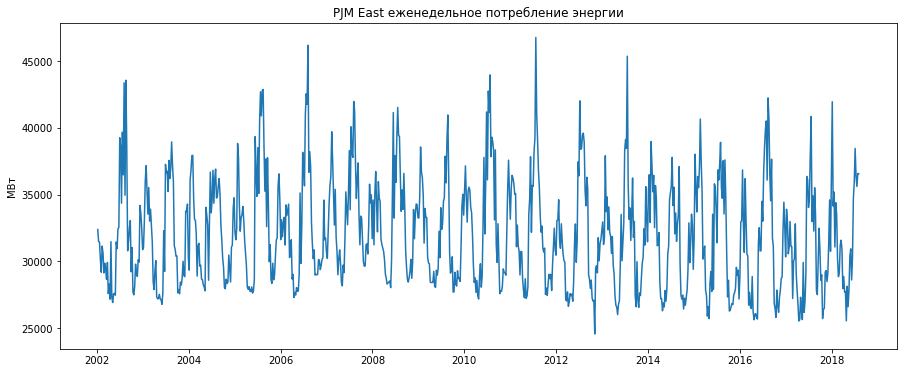

In [105]:
plt.figure(figsize =(15, 6))
plt.plot( data_w.index, data_w['PJME_MW'].values)
plt.title('PJM East еженедельное потребление энергии')
plt.ylabel ('МВт');

In [106]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [107]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
    data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [108]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [109]:
data_w = data_w.drop(['year', 'hour', 'dayofyear', 'dayofmonth', 'dayofweek'], axis=1).copy()

In [110]:
def createFeatures(data_w, p=7):
    
    
    scl = StandardScaler()
    tsne = TSNE(n_components=2)

    X = data_w.iloc[:,:-1]
    X = scl.fit_transform(X)
    Xt = tsne.fit_transform(X)

    clast_0 = DBSCAN(eps=5, leaf_size=15)
    clast_1 = DBSCAN(eps=2, leaf_size=5)

    data_w['cluster1'] = clast_0.fit_predict(Xt)
    data_w['cluster2'] = clast_1.fit_predict(X)
    
    pca = PCA(n_components=2, svd_solver='full')
    Xpca=pca.fit_transform(X)
    
    data_w['pca1']=Xpca[:,0]
    data_w['pca2']=Xpca[:,1]
    
    data_w['diff1'] = data_w.iloc[:, 0].diff()
    data_w['diff1'].fillna(0, inplace=True)

    for i in range(1, p):
        data_w[f't{i}'] = 0.0
        data_w[f't{i}'].values[i:] = data_w['PJME_MW'].values[:-i]
        data_w[f'd{i}'] = 0.0
        data_w[f'd{i}'].values[i:] = data_w['diff1'].values[:-i]

    for i in range(1,9):
        data_w[f'exp_0{i}'] = exponential_smoothing(data_w['PJME_MW'], i/100)
        
    return data_w

In [111]:
def getXy(data_w, h, p=7):
    scl_target = StandardScaler() 
    target = data_w['PJME_MW'].values[h+p:].reshape((data_w.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)

    scl_x=StandardScaler() 
    X = data_w.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    return X, y, scl_target

In [112]:
def getFeatures(X, y):
    
    sfk = SelectKBest(f_regression, k=5)
    sfk.fit_transform(X, y.ravel())

    sfp=SelectPercentile(f_regression, percentile=10)
    sfp.fit_transform(X, y.ravel())

    gr_model = GradientBoostingRegressor(max_depth=3, random_state=21, n_estimators=100).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)
    sfm.fit_transform(X, y.ravel())

    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    features = list(set(list(list_param_k) + list(list_param_m) + list(list_param_p)))

    print('SelectKBest : ',list_param_k)
    print('SelectPercentile: ',list_param_p)
    print(' SelectFromModel : ',list_param_m)

    print('Features: ',list(data_w.columns[features]))
    
    return features

In [113]:
def modeling(X, y, train, test, features):
    X_new = X[:,features]

    X_train =X_new[:train.shape[0],:]
    y_train =y[:train.shape[0],0]
    X_test =X_new[train.shape[0]:,:]
    y_test =y[train.shape[0]:,0]


    model = GradientBoostingRegressor(max_depth=3, random_state=21, n_estimators=100)
    model.fit( X_train, y_train )
    y_pred = model.predict(X_test)

    plt.figure( figsize=( 15, 7 ))


    plt.xlabel('Время')
    plt.ylabel('Потребление энергии, МВт')
    plt.plot(test.index[h+p:],y_pred, label='predict GB data' )
    plt.plot(test.index[h+p:],y_test, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform(y_test),
                                          y_pred = scl_target.inverse_transform(y_pred))

    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

SelectKBest :  [ 0 12 15 20 22]
SelectPercentile:  [ 0 12 20 22]
 SelectFromModel :  [ 0  1  3  9 22]
Features:  ['PJME_MW', 'month', 'weekofyear', 'pca1', 't1', 'd2', 't5', 't6']


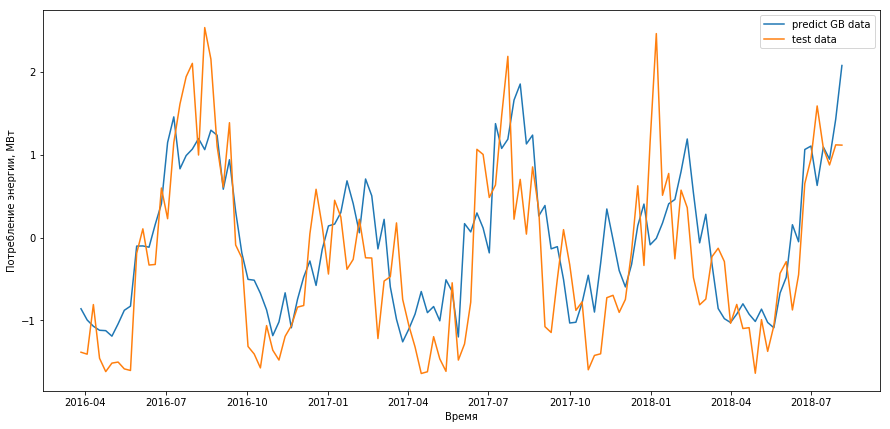

ошибка градиентного бустинга MAPE :   7.347679244793409 %


In [114]:
h = 4
p = 7

data_w = createFeatures(data_w, p)
X, y, scl_target = getXy(data_w, h, p)
features = getFeatures(X, y)

train, test = split_data( data_w, '01-06-2016')

modeling(X, y, train, test, features)

SelectKBest :  [ 0 12 14 16 18]
SelectPercentile:  [ 0 12 14 16]
 SelectFromModel :  [ 0 12 22]
Features:  ['PJME_MW', 't1', 't2', 't3', 't4', 't6']


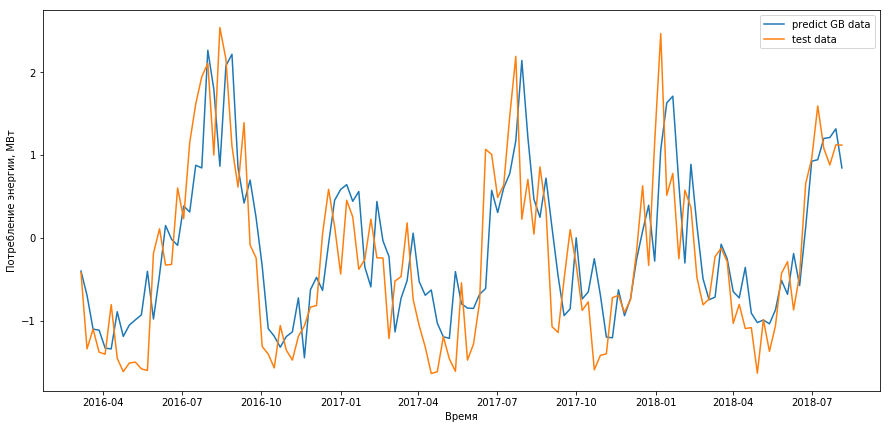

ошибка градиентного бустинга MAPE :   6.729739273216246 %


In [115]:
h = 1
p = 7

data_w = createFeatures(data_w, p)
X, y, _ = getXy(data_w, h, p)
features = getFeatures(X, y)
modeling(X, y, train, test, features)

In [116]:
h = 4
p = 7

data_w = createFeatures(data_w, p)
X, y, _ = getXy(data_w, h, p)
features = getFeatures(X, y)

X_new = X[:,features]

X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]


model = GradientBoostingRegressor(max_depth=3, random_state=21, n_estimators=100)
model.fit( X_train, y_train )
y_pred = model.predict(X_test)

SelectKBest :  [ 0 12 15 20 22]
SelectPercentile:  [ 0 12 20 22]
 SelectFromModel :  [ 0  1  3 20 22]
Features:  ['PJME_MW', 'month', 'weekofyear', 't1', 'd2', 't5', 't6']


In [117]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

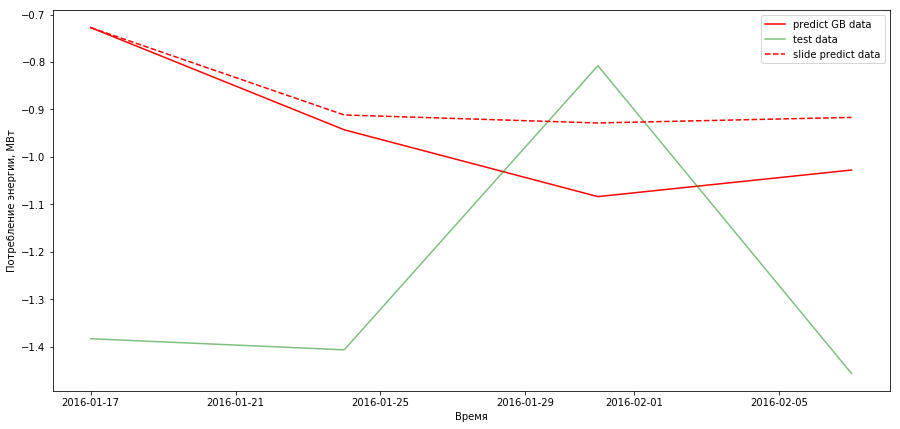

ошибка градиентного бустинга MAPE :   6.80379903565677 %


In [118]:
scaler=StandardScaler()
X_test_100 = X_test.copy()
y_test_100 = y_pred.copy()
N = 4

for i in range(N):
    y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    y_i = scl_target.inverse_transform(y_test_100[i:i+1]) 
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    X_test_100[i+1,3] = X_test_100[i, 0]
    X_test_100[i+1,4] = 0 if i<2 else X_test_100[i-4, 0]
    X_test_100[i+1,5] = 0 if i<3 else X_test_100[i-5, 0]
    X_test_100[i+1,6] = 0 if i<4 else X_test_100[i-6, 0]
        
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N+1],y_pred[:N], 'r',label='predict GB data' )
plt.plot(test.index[1:N+1],y_test[:N], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N+1],y_test_100[:N], '--r',label='slide predict data')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true = scl_target.inverse_transform( y_test[:N]),
                                      y_pred = scl_target.inverse_transform( y_test_100[:N]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

In [119]:
y_test_pred_g = model.predict(X_test)

In [120]:
scl_x=StandardScaler() 

X = data_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))

In [121]:
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()

arr_er_g = {'Интервал':[],'НИТ':[]}
N10=100
for i in range(N10):
    y_test_100[i] = model.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    if i < y_test_100.shape[0]-1:
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        if i>=4:
            X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
        if i>=1:
            X_test_100[i+1,3] = X_test_100[i-1+1,0]     
        if i>=2:
            X_test_100[i+1,4] = X_test_100[i-2+1,0]  
        if i>=3:
            X_test_100[i+1,5] = X_test_100[i-3+1,0]  
        if i>=7:
            X_test_100[i+1,6] = X_test_100[i-7+1,0]   
    if i % 10 == 9:
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[i-9:i]),y_pred = scl_target.inverse_transform( y_test_100[i-9:i]))
        arr_er_g['Интервал'].append(er_g)
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[:i]),y_pred = scl_target.inverse_transform( y_test_100[:i]))
        arr_er_g['НИТ'].append(er_g)

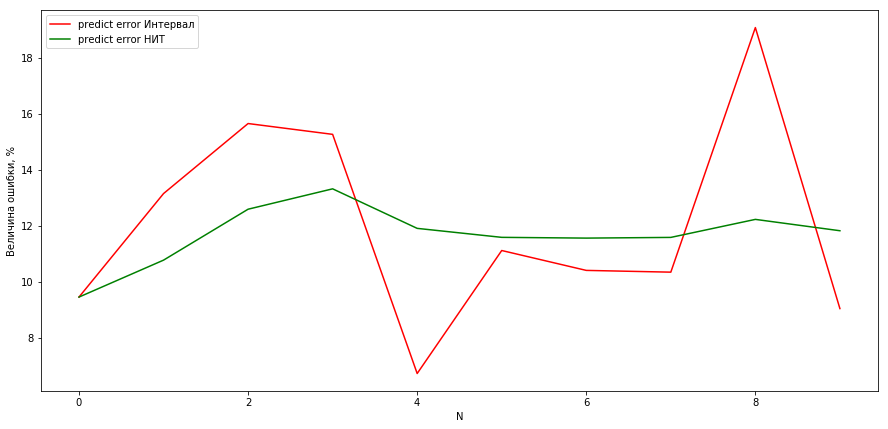

In [122]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('N')
plt.ylabel('Величина ошибки, %')
i = range(len(arr_er_g['Интервал']))
plt.plot(i ,arr_er_g['Интервал'], 'r',label='predict error Интервал' )
plt.plot(i ,arr_er_g['НИТ'], 'g',label='predict error НИТ' )
plt.legend()
plt.show()

Ошибка прогноза все время скачет, относительная ошибка повторяет нижние и верхние пики, но  с меньшей амплитудой